In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile = '../test7/ntuple_SingleMuon_Toy3_2GeV.0.root'
#infile = '../test7/ntuple_SingleMuon_Toy3_3GeV.0.root'
#infile = '../test7/ntuple_SingleMuon_Toy3_4GeV.0.root'
#infile = '../test7/ntuple_SingleMuon_Toy3_5GeV.0.root'

infile_r = root_open(infile)
tree = infile_r.ntupler.tree
ttstub_tree = infile_r.ttstubntupler.tree

tree.define_collection(name='hits', prefix='vh_', size='vh_size')
tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
tree.define_collection(name='particles', prefix='vp_', size='vp_size')

ttstub_tree.define_collection(name='hits', prefix='vh_', size='vh_size')

In [4]:
hits_phi = [np.pi/4] * 10
hits_r = [0.] * 10
hits_z = [0.] * 10

for ievt, (evt1, evt2) in enumerate(zip(tree, ttstub_tree)):
  print("evt {0}".format(ievt))
  
  # EMTF hits
  for ihit, hit in enumerate(evt1.hits):
    print(".. hit {0} {1} {2} {3}".format(ihit, np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z))
    phi, r, z = np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z
    hits_phi.append(phi)
    hits_r.append(r)
    hits_z.append(z)

  # TT hits
  for ihit, hit in enumerate(evt2.hits):
    print(".. hit {0} {1} {2} {3}".format(ihit + len(evt1.hits), np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z))
    phi, r, z = np.deg2rad(hit.sim_phi), hit.sim_r, hit.sim_z
    hits_phi.append(phi)
    hits_r.append(r)
    hits_z.append(z)
    
hits_phi = np.asarray(hits_phi)
hits_r = np.asarray(hits_r)
hits_z = np.asarray(hits_z)

idx = np.argsort(hits_r)
hits_phi = hits_phi[idx]
hits_r = hits_r[idx]
hits_z = hits_z[idx]

hits_phi = hits_phi - np.pi/4

evt 0
.. hit 0 1.25177745824 173.226318359 565.368774414
.. hit 1 1.2698645831 175.08807373 586.451965332
.. hit 2 1.41811463834 241.180831909 796.001220703
.. hit 3 1.25177745824 173.226318359 565.368774414
.. hit 4 1.41846550981 241.561431885 839.764343262
.. hit 5 1.4044295856 266.80770874 923.842834473
.. hit 6 1.38399768056 272.347900391 964.5
.. hit 7 1.36258067223 297.229156494 1013.73809814
.. hit 8 1.34379353548 311.940582275 1054.99499512
.. hit 9 1.2698645831 175.08807373 586.451965332
.. hit 10 0.90146578108 40.0739479065 133.207000732
.. hit 11 0.921687096658 47.2307128906 155.942993164
.. hit 12 0.947371953791 56.1897239685 184.397003174
.. hit 13 1.02045535253 80.6470870972 265.829986572
.. hit 14 0.858022100271 24.9283084869 85.2337417603
.. hit 15 0.889390076591 35.9229431152 119.830566406
evt 1
.. hit 0 1.25177745824 173.226318359 565.368774414
.. hit 1 1.2698645831 175.08807373 586.451965332
.. hit 2 1.41811463834 241.180831909 796.001220703
.. hit 3 1.25177745824 17

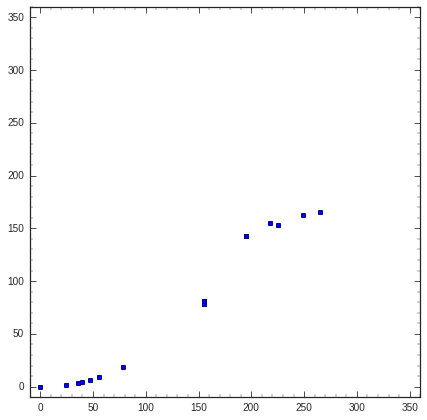

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_r*np.cos(hits_phi), hits_r*np.sin(hits_phi))
ax.set_xlim(-10,360)
ax.set_ylim(-10,360)
plt.show()

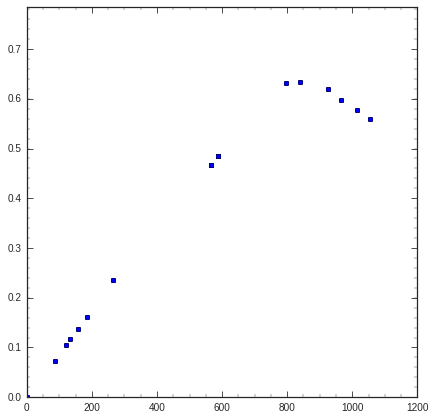

In [6]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_z, hits_phi)
ax.set_xlim(0,1200)
ax.set_ylim(0,np.pi/4)
plt.show()

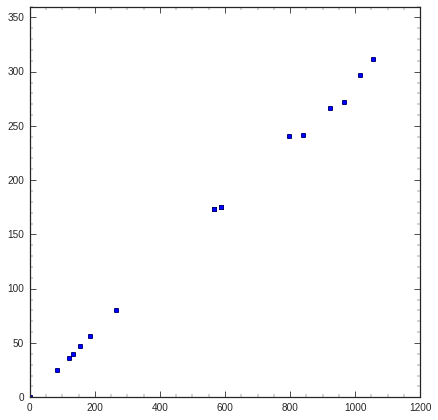

In [7]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_z, hits_r)
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

### Interpolation

In [8]:
lins_z = np.linspace(0,1080,num=101)

print hits_z.shape, np.max(hits_z)

(340,) 1054.9949951171875


In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-2, 1e2)) * RBF(360, (1e-1, 1e5))
alpha = 0.01
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gp.fit(np.atleast_2d(hits_z).T, hits_phi)
print kernel.get_params()
print gp.kernel_.get_params()

{'k1__constant_value': 1.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 1**2, 'k1__constant_value_bounds': (0.01, 100.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 0.12387146120452915, 'k2__length_scale': 475.06564505535016, 'k2': RBF(length_scale=475), 'k1': 0.352**2, 'k1__constant_value_bounds': (0.01, 100.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


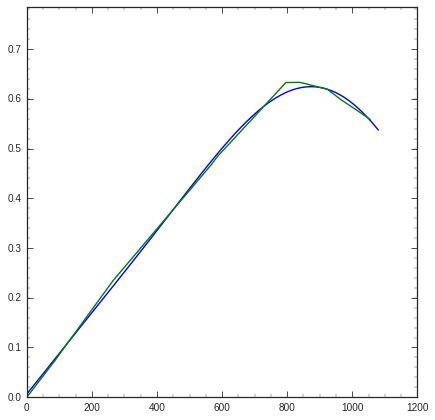

In [10]:
lins_phi, sigma = gp.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_phi)
ax.plot(hits_z, hits_phi)
ax.set_xlim(0,1200)
ax.set_ylim(0,np.pi/4)
plt.show()

In [11]:
kernel = C(100.0, (1e-2, 1e5)) * RBF(360, (1e-1, 1e5))
alpha = 0.01 * 20000
gpx = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gpx.fit(np.atleast_2d(hits_z).T, hits_r * np.cos(hits_phi))
print kernel.get_params()
print gpx.kernel_.get_params()

{'k1__constant_value': 100.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 10**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 71074.19988723348, 'k2__length_scale': 588.9885183093817, 'k2': RBF(length_scale=589), 'k1': 267**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


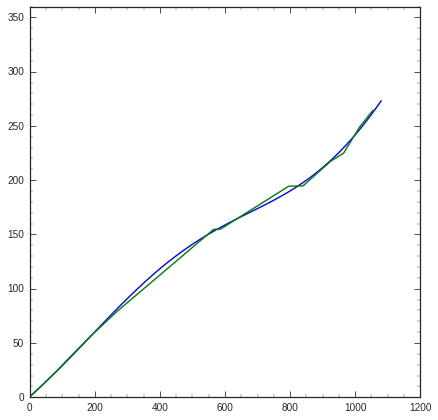

In [12]:
lins_x, sigma = gpx.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_x)
ax.plot(hits_z, hits_r * np.cos(hits_phi))
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

In [13]:
gpy = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gpy.fit(np.atleast_2d(hits_z).T, hits_r * np.sin(hits_phi))
print kernel.get_params()
print gpy.kernel_.get_params()

{'k1__constant_value': 100.0, 'k2__length_scale': 360, 'k2': RBF(length_scale=360), 'k1': 10**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}
{'k1__constant_value': 7552.884861483058, 'k2__length_scale': 554.1399195964658, 'k2': RBF(length_scale=554), 'k1': 86.9**2, 'k1__constant_value_bounds': (0.01, 100000.0), 'k2__length_scale_bounds': (0.1, 100000.0)}


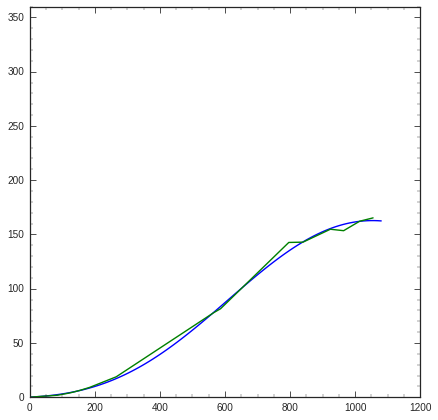

In [14]:
lins_y, sigma = gpy.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_z, lins_y)
ax.plot(hits_z, hits_r * np.sin(hits_phi))
ax.set_xlim(0,1200)
ax.set_ylim(0,360)
plt.show()

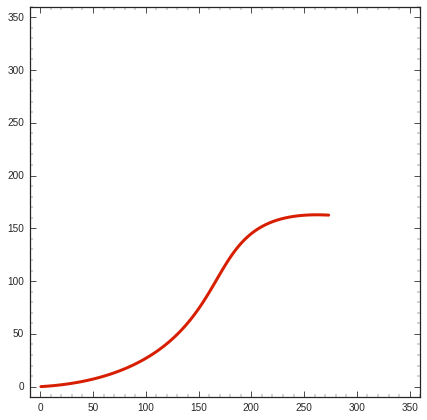

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(lins_x, lins_y, c='#D81E00', lw=3)
ax.set_xlim(-10,360)
ax.set_ylim(-10,360)
plt.show()